In [1]:
'''
 swing up pendulum with limited torque
'''
import sympy as sp
import numpy as np

import sys
sys.path.append('../')

from ilqr import iLQR
from ilqr.utils import GetSyms, Constrain, Bounded
from ilqr.containers import Dynamics, Cost

In [6]:
#state and action dimensions
n_x = 4
n_u = 1
#time step
dt = 0.02
    
def f(x,u,M=.5,m=.2,l=.3,b=.1,I=.006):
    """ cart pendulum 
        model from: https://ctms.engin.umich.edu/CTMS/index.php?example=InvertedPendulum&section=SystemModeling
            -- downwards: theta = 0
            -- upwards: theta = np.pi
        return: ddt[cart_position, arm_angle, cart_velocity, arm_rate]
    """
    # 
    g = 9.81
    [xi1, xi2, xi3, xi4] = x
    xi5 = u[0]
    m1 = M
    m2 = m
    xdot  = np.array([xi3,
        xi4,
        1/(m1+m2*(1-np.cos(xi2)**2))*(l*m2*np.sin(xi2)*xi4**2+xi5+m2*g*np.cos(xi2)*np.sin(xi2)),
        -1/(l*m1+l*m2*(1-np.cos(xi2)**2))*(l*m2*np.cos(xi2)*np.sin(xi2)*(xi4)**2+xi5*np.cos(xi2)+(m1+m2)*g*np.sin(xi2))])
    return xdot

#call dynamics container
dynS = Dynamics.Continuous(f, dt=dt)

#Construct cost to swing up Pendulum
x, u = GetSyms(n_x, n_u)
#initial state
#theta = pi --> sin(theta) = 0, cos(theta) = -1
x0 = np.array([0, 0, 0, 0])
#theta = 0 --> sin(theta) = 0, cos(theta) = 1
x_goal = np.array([0, np.pi, 0, 0])

Q  = np.diag([1, 10, 1, 1])*0
R  = np.diag([0.3])
QT = np.diag([10, 1000, 10, 10])
#Add constraints on torque input (2Nm to -2Nm)
cons = Bounded(u, high = [.7], low = [-.7])
SwingUpCost = Cost.QR(Q, R, QT, x_goal, cons)



In [3]:
#state and action dimensions
n_x = 4
n_u = 1
#time step
dt = 0.02

def furuta_pen(x,u,m2=.127,l1=.2,l2=.3):
    j1 = 0.0012
    lc2 = 0.15
    beta1 = 0.015
    beta2 = 0.002
    r = 2.6
    kc = 0.00768
    kv = kc
    kr = 70
    
    g = 9.81

    comm = r/(kc*kr)
    a1 = comm*(j1+m2*l1**2)
    a2 = comm*m2*l2**2/3
    a3 = comm*m2*l1*l2/2
    a4 = comm*m2*lc2*g
    a5 = beta1*comm + kv
    a6 = beta2*comm
    
    [xi1, xi2, xi3, xi4] = x
    xi5 = u
    cos = np.cos
    sin = np.sin
    
    U = np.array([[a1+a2*sin(xi2)**2, a3*cos(xi2)],
        [a3*cos(xi2), a2]])
    V = np.array([a5*xi3-a3*sin(xi2)*xi4**2+2*a2*sin(xi2)*cos(xi2)*xi3*xi4,
        -a2*sin(xi2)*cos(xi2)*xi3**2+a6*xi4-a4*sin(xi2)])

    xdot = np.linalg.inv(U)@(np.array([xi5, 0]) - V)
    
    # return: ddt[arm1_theta, arm2_theta, arm1_rate, arm2_rate]
    return xdot


#call dynamics container
dynS = Dynamics.Continuous(f, dt=dt)

#Construct cost to swing up Pendulum
x, u = GetSyms(n_x, n_u)
#theta = 0 --> sin(theta) = 0, cos(theta) = 1
x_goal = np.array([0, 0, 0, 0])
#initial state
#theta = pi --> sin(theta) = 0, cos(theta) = -1
x0 = np.array([0, np.pi, 0, 0])

Q  = np.diag([1, 10, 1, 1])*0
R  = np.diag([0.3])
QT = np.diag([10, 1000, 10, 10])
#Add constraints on torque input (2Nm to -2Nm)
cons = Bounded(u, high = [5], low = [-5])
SwingUpCost = Cost.QR(Q, R, QT, x_goal, cons)

In [9]:


#initialise the controller
controller = iLQR(dynS, SwingUpCost)

#initial guess
us_init = np.random.randn(200, n_u)*0.0
#get optimal states and actions
xs, us, cost_trace = controller.fit(x0, us_init,maxiters=500)

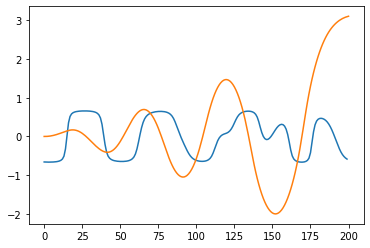

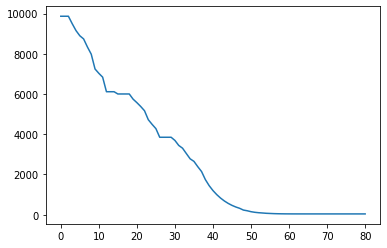

[-0.06695308  3.10602712  0.02860755  0.42048669]


In [10]:
import matplotlib.pyplot as plt

plt.figure(1)
plt.plot(us)
plt.plot(xs[:,1])

plt.figure(2)
plt.plot(cost_trace)
plt.show()

print(xs[-1,:])